In [35]:
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm
from dateutil import parser
from datetime import datetime

In [36]:
df = pd.read_json('./calllog.json')
print(df.shape)
df.head()

(16877, 4)


,number,calltype,duration,date
0,7958309153,incomming-missed,0,2020-02-13 07:30:04.464000+00:00
1,7958309153,outgoing-rejected,0,2020-06-12 01:29:16.039000+00:00
2,7958309153,incomming-connected,4797,2020-10-07 01:03:33.778000+00:00
3,7958309153,incomming-connected,4741,2020-09-05 12:46:02.822000+00:00
4,7958309153,incomming-connected,2082,2020-09-13 04:05:35.482000+00:00


In [37]:
df.calltype.unique()

array(['incomming-missed', 'outgoing-rejected', 'incomming-connected',
       'incomming-rejected', 'outgoing-connected',
       'outgoing-notconnected'], dtype=object)

In [38]:
df = df.sort_values(by='date', ascending=False)

In [39]:
df['callStatus'] = df.calltype.apply(lambda x: x.split('-')[0])
# df['callStatus2'] = df.calltype.apply(lambda x: x.split('-')[1])
#df['timeStampMilli'] = df.date.apply(lambda x: parser.parse(str(x)).microsecond)
df.head(n=5)

,number,calltype,duration,date,callStatus
7967,6949168770,outgoing-connected,4247,2020-12-31 23:53:36.841000+00:00,outgoing
12303,9098179455,incomming-missed,0,2020-12-31 23:53:12.472000+00:00,incomming
15845,9837612527,outgoing-rejected,0,2020-12-31 23:14:34.208000+00:00,outgoing
14441,9874841426,incomming-rejected,0,2020-12-31 21:52:14.488000+00:00,incomming
492,9800684503,outgoing-notconnected,0,2020-12-31 21:29:01.170000+00:00,outgoing


### Number

In [40]:
number = np.array(df.number.unique())
number.shape

(1000,)

### Frequency

In [41]:
total_outgoing = df['callStatus'].value_counts()[0]  #Total Outgoing Calls
total_incoming = df['callStatus'].value_counts()[1]  #Total Incoming Calls

In [42]:
def frequency(number):
    """ Calculates Frequency for outgoing call from A to B """
    
    C_AB = 0
    C_AK = total_outgoing
    sub_df = df[df['number'] == number]
    C_AB = sub_df[sub_df['callStatus'] == 'outgoing'].shape[0]
                
    return C_AB/C_AK

### Intimacy

In [43]:
D_AK = df.groupby(['callStatus'])['duration'].sum()['outgoing']  #total outgoing call duration
D_KA = df.groupby(['callStatus'])['duration'].sum()['incomming']  #total incoming call duration

In [44]:
df.groupby(['callStatus'])['duration'].sum()

callStatus
incomming    7445000
outgoing     7719708
Name: duration, dtype: int64

In [45]:
x = df.groupby(['callStatus'])['duration'].sum()
x.head(n=5)

callStatus
incomming    7445000
outgoing     7719708
Name: duration, dtype: int64

In [46]:
def intimacy(number):
    """ Calculates Intimacy for outgoing call from A to B """
    
    tendency = D_AK/(D_AK + D_KA)
    sub_df = df[df['number'] == number]
    
    #Duration of outgoing calling 
    try: 
        D_AB = sub_df.groupby(['callStatus'])['duration'].sum()['outgoing']
    except:
        D_AB = 0
        
    #Duration of incoming calling
    try:
        D_BA = sub_df.groupby(['callStatus'])['duration'].sum()['incomming']
    except:
        D_BA = 0
    
    S_AB = D_AB/(D_AK + D_KA)
    R_BA = D_BA/(D_AK + D_KA)
    
    return tendency * S_AB + (1-tendency) * R_BA

### Recency

In [47]:
def get_millisecond(timestamp):
    sample = datetime.strptime(str(timestamp), '%Y-%m-%d %H:%M:%S.%f+00:00')
    milisec = sample.timestamp()*1000
    return milisec

In [48]:
T_AK_Max = get_millisecond(df.iloc[0,3])   #Max Timestamp
T_AK_Min = get_millisecond(df.iloc[-1,3]) #Min Timestamp 

In [49]:
def recency(number):
    sub_df = df[df['number'] == number]
    T_AB = get_millisecond(sub_df.iloc[0,3])    #timestamp for recent call between A to B
    
    return (T_AB - T_AK_Min)/(T_AK_Max-T_AK_Min)


### Build Dataset with Features

In [50]:
Values = np.zeros((1000,4)).astype('int64')
Values.shape

(1000, 4)

In [51]:
col_names = ['Number','Frequency','Intimacy','Recency']
callLogDataframe = pd.DataFrame(data=Values, columns=col_names)
callLogDataframe.head()

,Number,Frequency,Intimacy,Recency
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [52]:
for i in tqdm(range(1000)):
    callLogDataframe.iloc[i,0] = number[i]
    callLogDataframe.iloc[i,1] = frequency(callLogDataframe.iloc[i,0])
    callLogDataframe.iloc[i,2] = intimacy(callLogDataframe.iloc[i,0])
    callLogDataframe.iloc[i,3] = recency(callLogDataframe.iloc[i,0])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.13it/s]


In [53]:
callLogDataframe.head()

,Number,Frequency,Intimacy,Recency
0,6949168770,0.000824,0.000685,1.000000
1,9098179455,0.001177,0.000243,0.999999
2,9837612527,0.002237,0.000767,0.999926
3,9874841426,0.003296,0.001804,0.999770
4,9800684503,0.001413,0.000483,0.999726


## K-Means

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [55]:
sub_log = callLogDataframe[['Frequency','Intimacy','Recency']]

mms = MinMaxScaler()
X = mms.fit_transform(sub_log)

In [56]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300,
)

label = km.fit_predict(X)

In [57]:
sub_log['label'] = label
sub_log['Frequency'] = X[:,0]
sub_log['Intimacy'] = X[:,1]
sub_log['Recency'] = X[:,2]

sub_log.head()

,Frequency,Intimacy,Recency,label
0,0.225806,0.276533,1.000000,3
1,0.322581,0.098190,0.999999,3
2,0.612903,0.309726,0.999914,1
3,0.903226,0.728687,0.999732,1
4,0.387097,0.195148,0.999680,3


In [58]:
sub_log['label'].value_counts()

2    412
3    371
1    164
0     53
Name: label, dtype: int64

In [59]:
mapping_dict = {
    0 : 'Spam',
    1 : 'High',
    2 : 'Low',
    3 : 'Medium'
}

sub_log['label'] = sub_log['label'].map(mapping_dict)
sub_log.head()

,Frequency,Intimacy,Recency,label
0,0.225806,0.276533,1.000000,Medium
1,0.322581,0.098190,0.999999,Medium
2,0.612903,0.309726,0.999914,High
3,0.903226,0.728687,0.999732,High
4,0.387097,0.195148,0.999680,Medium


In [60]:
sub_log['Number'] = callLogDataframe['Number']
sub_log.head()

,Frequency,Intimacy,Recency,label,Number
0,0.225806,0.276533,1.000000,Medium,6949168770
1,0.322581,0.098190,0.999999,Medium,9098179455
2,0.612903,0.309726,0.999914,High,9837612527
3,0.903226,0.728687,0.999732,High,9874841426
4,0.387097,0.195148,0.999680,Medium,9800684503


In [61]:
if os.path.exists('./Call_Log_Feature.csv'):
    os.remove('./Call_Log_Feature.csv')
sub_log.to_csv('./Call_Log_Feature.csv',index=False)

### Plot Call Log Feature Data

In [62]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

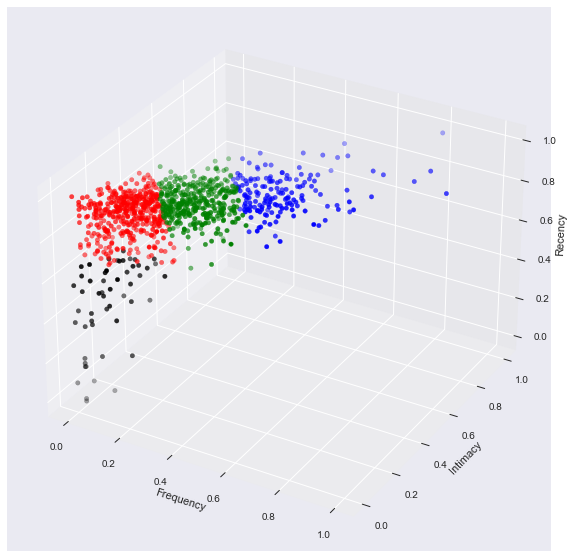

In [63]:
fig = plt.figure(figsize=(24,10))
ax = plt.axes(projection ='3d')

labels = ['Spam', 'Low', 'Medium', 'High']
c = ['black', 'red', 'green', 'blue']
for i,label in enumerate(labels):
    sub_log_ = sub_log[sub_log['label']==label]
    ax.scatter(sub_log_['Frequency'], sub_log_['Intimacy'], sub_log_['Recency'], color = c[i] )
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Intimacy')
    ax.set_zlabel('Recency')
plt.show()

In [64]:
sub_log['label'].value_counts()

Low       412
Medium    371
High      164
Spam       53
Name: label, dtype: int64

### ANN Model Train

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [32]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

adam = Adam(lr=1e-3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


In [33]:
reverse_map = {
    'Spam' : 0,
    'Low' : 1,
    'Medium' : 2,
    'High' : 3
}

sub_log = sub_log.sample(frac=1)

X = sub_log.drop(['label'],axis=1)
Y = sub_log['label']
Y = Y.map(reverse_map)

x_train,x_test, y_train,y_test = train_test_split(X,Y, test_size=0.2)
y_train = to_categorical(y_train)
# x_train = x_train.values#.reshape((800,3,1))
# x_test = x_test.values#.reshape((200,3,1))

In [34]:
model.fit(x_train,y_train,epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


ValueError: in user code:

    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\princ\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape [None, 4]
